#Desafio Final : Reclamações do Consumidor

###Squads: Mae C. Jemison & Marie Curie

> Nomes: Ana Caroline de Souza, Ana Luisa Fuchs, Carla Marra, Eduarda Martins, Edwiges Barbara, Glauce Gomes, <br>Grazielle Henrique, Juliana Portela, Leli Maria Araújo, Raquel Mitie e Sandra Resende.

In [ ]:
#Importação das bibliotecas - Ana
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Código para exibir todas as colunas do dataframe
pd.set_option('display.max_columns', None)

In [ ]:
## Função para importação dos datasets e criação de um arquivo único contendo todas as reclamações em seus respectivos anos (2017-2021).

from typing import List

def load_csv_files(file_paths: List[str], column_names: List[str], separator: str = ';') -> pd.DataFrame:
    """
    Carrega múltiplos arquivos CSV e os combina em um único DataFrame.

    :param file_paths: Lista de caminhos para os arquivos CSV.
    :param column_names: Lista dos nomes das colunas para os arquivos CSV.
    :param separator: Separador usado nos arquivos CSV (padrão é ';').
    :return: DataFrame contendo os dados combinados de todos os arquivos CSV.
    """
    dataframes = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=separator, header=0, names=column_names, low_memory=False)
        except pd.errors.ParserError:
            df = pd.read_csv(file_path, sep=separator, header=0, names=column_names, on_bad_lines='skip', low_memory=False)
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

# Lista de caminhos para os arquivos CSV
csv_files = ['reclamacoes-fundamentadas-sindec-2017.csv', 'reclamacoes-fundamentadas-sindec-2018.csv', 'reclamacoes-fundamentadas-sindec-2019.csv', 'reclamacoes-fundamentadas-sindec-2020.csv', 'reclamacoes-fundamentadas-sindec-2021.csv']

# Lista com os nomes das colunas
column_names = [
    "AnoCalendario", "DataArquivamento", "DataAbertura", "CodigoRegiao", "Regiao", "UF", "strRazaoSocial",
    "strNomeFantasia", "Tipo", "NumeroCNPJ", "RadicalCNPJ", "RazaoSocialRFB", "NomeFantasiaRFB",
    "CNAEPrincipal", "DescCNAEPrincipal", "Atendida", "CodigoAssunto", "DescricaoAssunto",
    "CodigoProblema", "DescricaoProblema", "SexoConsumidor", "FaixaEtariaConsumidor", "CEPConsumidor"
]

# Carregar os arquivos CSV e combinar em um único DataFrame
combined_df = load_csv_files(csv_files, column_names)

# Exibir as primeiras linhas do DataFrame combinado para verificação
combined_df.head(2)

,AnoCalendario,DataArquivamento,DataAbertura,CodigoRegiao,Regiao,UF,strRazaoSocial,strNomeFantasia,Tipo,NumeroCNPJ,RadicalCNPJ,RazaoSocialRFB,NomeFantasiaRFB,CNAEPrincipal,DescCNAEPrincipal,Atendida,CodigoAssunto,DescricaoAssunto,CodigoProblema,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,CEPConsumidor
0,2017,2017-12-12 12:35:53.000,2017-07-31 16:03:45.000,3,Sudeste,SP,CLARO S/A,NET,1,4.043254e+13,40432544.0,NaN,NaN,NaN,NaN,S,186.0,Telefonia Fixa ( Plano de Expansão / Compra e ...,3844.0,Contrato - Rescisão/alteração unilateral,M,mais de 70 anos,4444000.0
1,2017,2017-12-12 12:40:07.000,2017-08-04 10:55:48.000,3,Sudeste,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,ELETROPAULO METROPOLITANA,1,6.169523e+13,61695227.0,ELETROPAULO METROPOLITANA ELETRICIDADE DE SAO ...,ELETROPAULO METROPOLITANA,3514000.0,DISTRIBUIÇÃO DE ENERGIA ELÉTRICA,N,185.0,Energia Elétrica,6030.0,PID - Pedido de Indenização por Danos Morais,F,entre 31 a 40 anos,4674110.0


In [ ]:
# Verifica as dimensões do dataframe com as bases de dados combinadas
combined_df.shape

(115921, 23)

In [ ]:
# Verifica os tipos de dados e quantos valores não nulos existem no dataframe criado
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115921 entries, 0 to 115920
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AnoCalendario          115921 non-null  int64  
 1   DataArquivamento       115896 non-null  object 
 2   DataAbertura           115909 non-null  object 
 3   CodigoRegiao           115921 non-null  int64  
 4   Regiao                 115921 non-null  object 
 5   UF                     115921 non-null  object 
 6   strRazaoSocial         115918 non-null  object 
 7   strNomeFantasia        95800 non-null   object 
 8   Tipo                   115921 non-null  int64  
 9   NumeroCNPJ             109662 non-null  float64
 10  RadicalCNPJ            109425 non-null  float64
 11  RazaoSocialRFB         100313 non-null  object 
 12  NomeFantasiaRFB        49180 non-null   object 
 13  CNAEPrincipal          100313 non-null  float64
 14  DescCNAEPrincipal      99749 non-nul

In [ ]:
# Análise de valores nulos, % de valores nulos e únicos
df_reclamacoes_dict = pd.DataFrame(combined_df.dtypes)
df_reclamacoes_dict.columns = ["Dtype"]
df_reclamacoes_dict['Valores_Nulos'] = combined_df.isnull().sum()
df_reclamacoes_dict['%_Valores_Nulos'] = (combined_df.isnull().sum() / combined_df.shape[0]) * 100
df_reclamacoes_dict['NUnique'] = combined_df.nunique()
df_reclamacoes_dict

,Dtype,Valores_Nulos,%_Valores_Nulos,NUnique
AnoCalendario,int64,0,0.000000,5
DataArquivamento,object,25,0.021566,59563
DataAbertura,object,12,0.010352,91126
CodigoRegiao,int64,0,0.000000,5
Regiao,object,0,0.000000,5
UF,object,0,0.000000,20
strRazaoSocial,object,3,0.002588,23880
strNomeFantasia,object,20121,17.357511,17892
Tipo,int64,0,0.000000,2
NumeroCNPJ,float64,6259,5.399367,18396


In [ ]:
# Funções para conversão de data (de string para date)

def convert_todate(df):
    for column in df.columns:
        if 'Data' in column:
            df[column] = pd.to_datetime(df[column])
    return df

# Cria função para calcular o tempo de uma reclamação ativa (DataArquivamento - DataAbertura), é expresso em dias
def interval(df):
    convert_todate(df)
    df['DiferencaTempo'] = df['DataArquivamento'] - df['DataAbertura']
    df['DiferencaTempoNum'] = df['DiferencaTempo'].dt.days
    return df


def coluna_tempo(list_df):
    for item in list_df:
        interval(item)
    return "Coluna de tempo criada com sucesso nos dataframes inseridos."


coluna_tempo([combined_df])

'Coluna de tempo criada com sucesso nos dataframes inseridos.'

## 1) Análise de Dados:


### a. Existe alguma sazonalidade na data de abertura de uma reclamação? Ou seja, mais consumidores abrem reclamações em determinada época do ano?


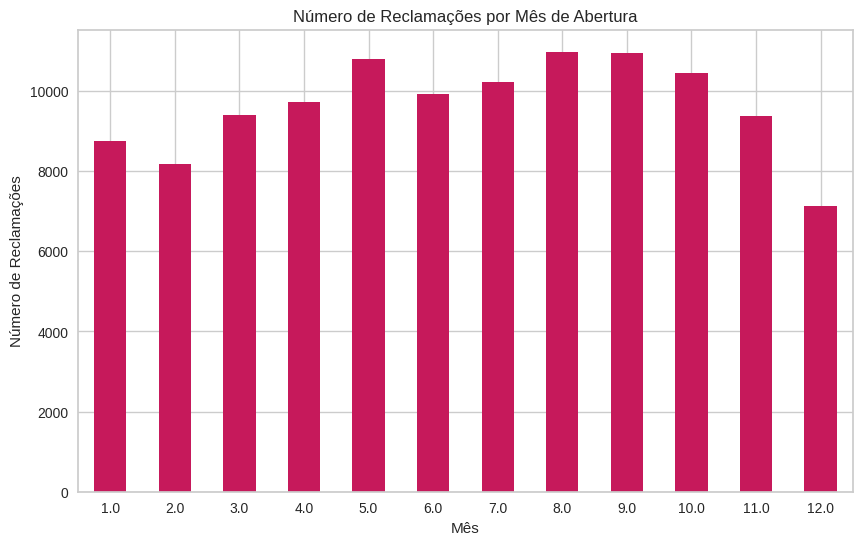

In [ ]:
# Convertendo as datas para o tipo datetime, se necessário
# Extraindo o mês da data de abertura
combined_df['MesAbertura'] = combined_df['DataAbertura'].dt.month

# Contagem de reclamações por mês
reclamacoes_por_mes = combined_df.groupby('MesAbertura').size()

# Gráfico de barras para visualizar a sazonalidade mensal
plt.figure(figsize=(10, 6))
reclamacoes_por_mes.plot(kind='bar', color='#c6195b')
plt.title('Número de Reclamações por Mês de Abertura')
plt.xlabel('Mês')
plt.ylabel('Número de Reclamações')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Filtrando os dados para o período de 2017 a 2021
combined_df_filtrado = combined_df.copy()
combined_df_filtrado = combined_df[(combined_df['DataAbertura'] >= '2017-01-01') & (combined_df['DataAbertura'] <= '2021-12-31')]

# Agrupando os dados por mês e contando o número de reclamações por mês
monthly_counts = combined_df_filtrado.groupby(combined_df['DataAbertura'].dt.to_period('M')).size()

# Convertendo para um DataFrame e definindo o índice como DatetimeIndex
monthly_counts = monthly_counts.to_frame(name='Contagem')
monthly_counts.index = monthly_counts.index.to_timestamp()

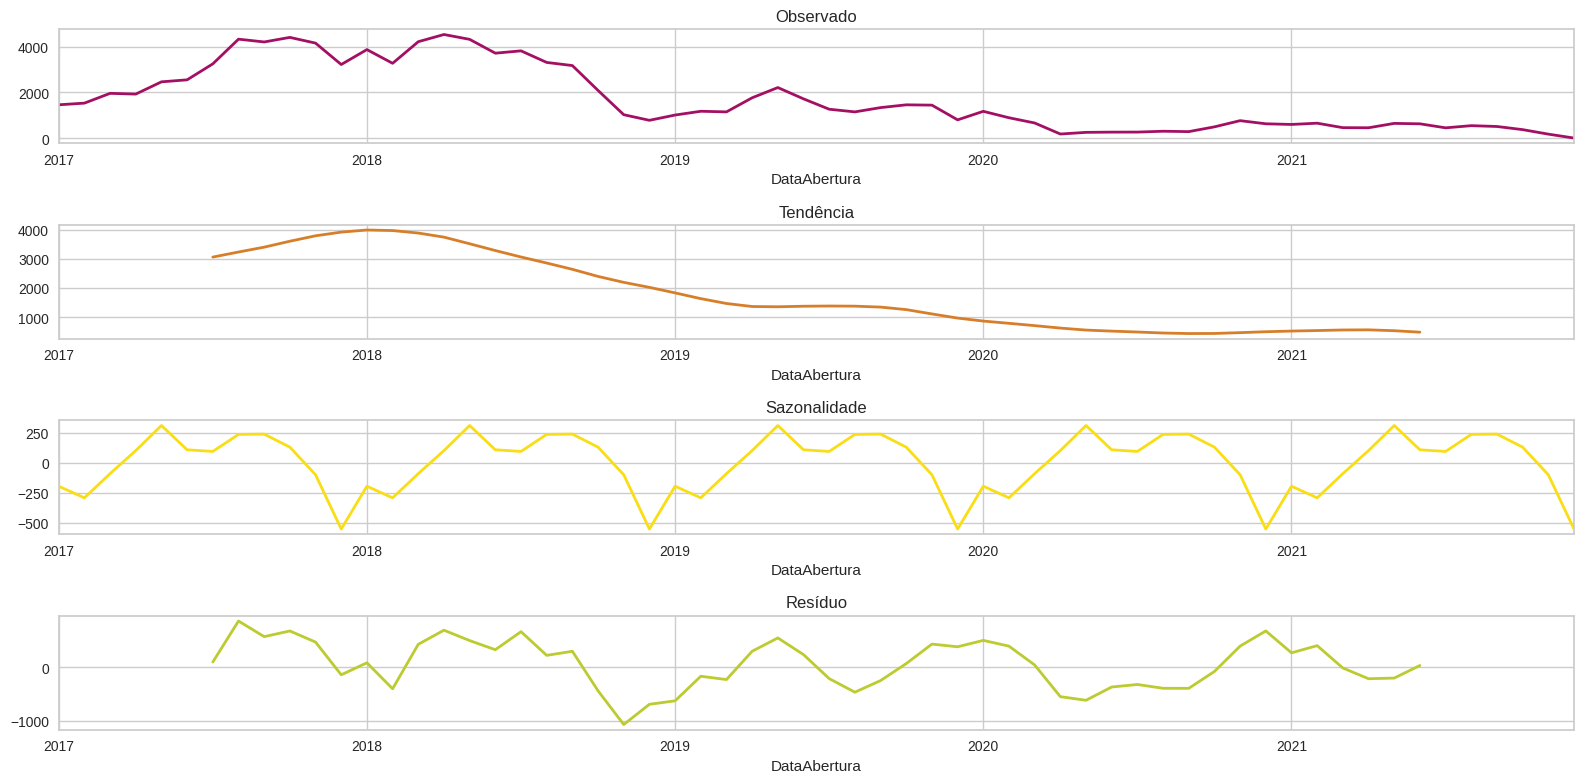

In [ ]:
# Realizando a decomposição sazonal
decomposition = seasonal_decompose(monthly_counts['Contagem'], model='additive')

# Plotando os resultados da decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 8))
decomposition.observed.plot(ax=ax1, color= '#a31063', linewidth=2)
ax1.set_title('Observado')
decomposition.trend.plot(ax=ax2, color= '#d77e2b', linewidth=2)
ax2.set_title('Tendência')
decomposition.seasonal.plot(ax=ax3, color= '#f9dd15', linewidth=2)
ax3.set_title('Sazonalidade')
decomposition.resid.plot(ax=ax4, color= '#bbcb30', linewidth=2)
ax4.set_title('Resíduo')
plt.tight_layout()
plt.show()

### b. Qual o tempo médio de uma reclamação ativa (da abertura até a data de fechamento)?

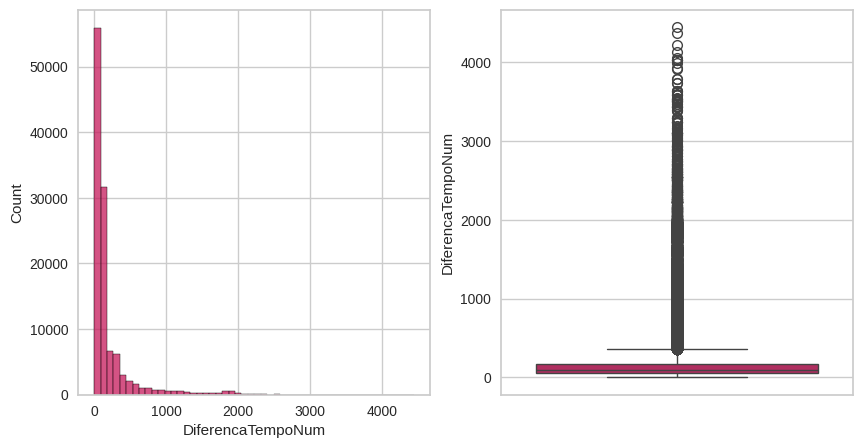

In [ ]:
#Boxplot e histograma das reclamações ativas, num perfil geral, para observar o comportamento dos dados
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
sns.histplot(combined_df, x = 'DiferencaTempoNum', bins = 50, ax=axs[0], color= '#c6195b')
sns.boxplot(combined_df, y = 'DiferencaTempoNum', ax=axs[1], color= '#c6195b');

Percebe-se a existência de muitos outliers, que acabam gerando a um gráfico com uma grande concentração dos números em menos de 1000 dias (assimetria positiva), porém existindo a presença de dados com tempos maiores de espera.

In [ ]:
# A média de reclamação ativa levando em consideração todos os registros e os outliers presentes
media_reclamacao_ativa = combined_df['DiferencaTempoNum'].mean().round()
print(f"O tempo médio de uma reclamação ativa é de {media_reclamacao_ativa} dias.")

O tempo médio de uma reclamação ativa é de 206.0 dias.


In [ ]:
# Calculando os valores de outliers do tempo de reclamação ativa
# Calcular Q1 (primeiro quartil) e Q3 (terceiro quartil)
Q1 = combined_df['DiferencaTempoNum'].quantile(0.25)
Q3 = combined_df['DiferencaTempoNum'].quantile(0.75)

# Calcular o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Calcular o limite superior
limite_superior = Q3 + 1.5 * IQR

# Filtra os outliers do dataset
df_sem_outlier = combined_df[(combined_df['DiferencaTempoNum'] < limite_superior)]
media_sem_outlier = df_sem_outlier['DiferencaTempoNum'].mean().round(2)
print('A média de tempo de reclamação ativa sem outliers é de {}.'.format(media_sem_outlier))  # Média sem outliers
print('A mediana de tempo de reclamação ativa com outliers é de {}.'.format(combined_df['DiferencaTempoNum'].median()))  # Mediana de todos os valores

A média de tempo de reclamação ativa sem outliers é de 99.06.
A mediana de tempo de reclamação ativa com outliers é de 91.0.


#### Observa-se que a proximidade da mediana com a média dos dados tratados, sendo a primeira contendo os outliers e a segunda não. Assim, a nível de manipulação, é preferível utilizar a mediana se considerar o dataset sem tratamento dos outliers.

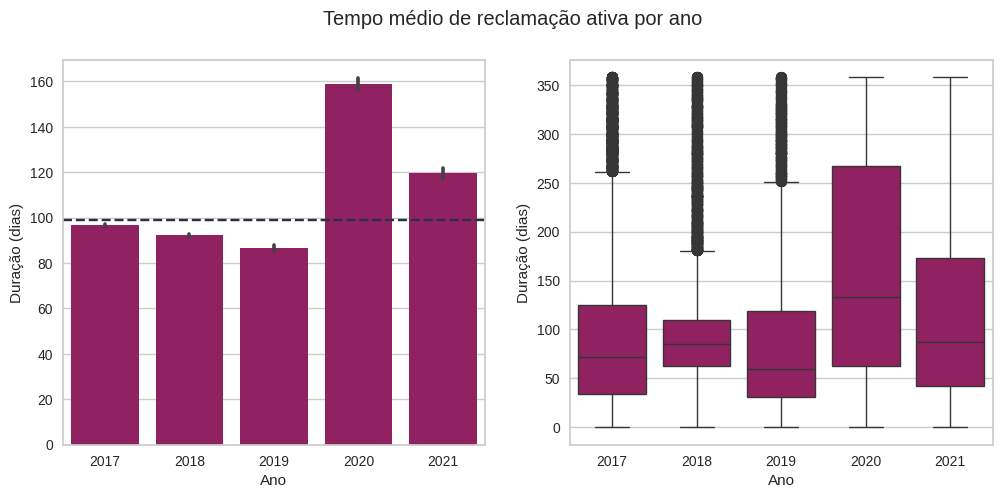

In [ ]:
#Boxplot e gráfico de barras a fim de comparar o tempo médio de reclamação ativa por seu respectivo ano sem outliers
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
ax1 = sns.barplot(df_sem_outlier, y = 'DiferencaTempoNum', x = 'AnoCalendario', ax=axs[0], color= '#a31063')
ax1.axhline(media_sem_outlier, color='#293049', linestyle='--') # Cria uma linha indicando a média entre todos os registros
ax2 = sns.boxplot(df_sem_outlier, y = 'DiferencaTempoNum', x = 'AnoCalendario', ax=axs[1], color= '#a31063');

plt.suptitle('Tempo médio de reclamação ativa por ano')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Duração (dias)')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Duração (dias)')
plt.show();

### EXTRA: Existe difença entre a reclamação ser atendida ou não em função da média de tempo da reclamação?

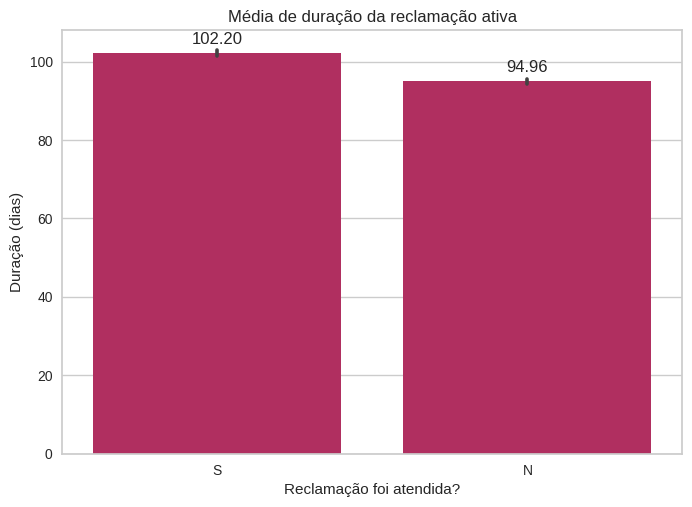

In [ ]:
#Plot do gráfico com os dados tratados (sem outliers) a fim de perceber se a diferença de ser Atendida ou não
#interfere estatisticamente no tempo de atendimento da reclamação

ax = sns.barplot(df_sem_outlier, x = 'Atendida', y = 'DiferencaTempoNum', color='#c6195b')

# Código para incluir o valor das médias no gráfico de barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points');

plt.title('Média de duração da reclamação ativa')
plt.xlabel('Reclamação foi atendida?')
plt.ylabel('Duração (dias)')
plt.xticks(rotation=0)
plt.show();

Percebe-se que a reclamação ativa possui, em dias, um tempo de duração semelhante com o fato de ser atendida ou não nos dados tratados. Para confirmar, podemos realizar testes estatísticos (teste T):

* H0: Ser atendida NÃO tem influência no tempo de reclamação ativa

In [ ]:
# Recalculando sem os outliers no tempo de reclamação ativa
df_sem_outlier = combined_df[(combined_df['DiferencaTempoNum'] < limite_superior)]

data3 = df_sem_outlier[df_sem_outlier['Atendida'] == 'S']['DiferencaTempoNum'].dropna()
data4 = df_sem_outlier[df_sem_outlier['Atendida'] == 'N']['DiferencaTempoNum'].dropna()

t_stat, p_value = stats.ttest_ind(data3, data4)

print(f'Estatística t: {t_stat}, p-valor: {p_value}')


if p_value < 0.05:
    print(
        'A variável categórica de SER ATENDIDA (ou seja, se a requisição foi atendida) TEM influência significativa no tempo de espera das requisições até esta ser encerrada')
else:
    print(
        'A variável categórica de SER ATENDIDA (ou seja, e a requisição foi atendida) NÃO tem influência no tempo de espera das requisições até esta ser encerrada')

Estatística t: 15.062812062385804, p-valor: 3.2354851845049086e-51
A variável categórica de SER ATENDIDA (ou seja, se a requisição foi atendida) TEM influência significativa no tempo de espera das requisições até esta ser encerrada


Reclamações que foram atendidas possuem maior tempo de reclamação ativa quando comparadas as reclamações não atendidas, confirmado pela hipótese alternativa.

* H0 = A média de tempo de atendimento de uma requisição NÃO variabilidade significativa nos diferentes anos.

In [ ]:
def get_filtered_values(df, year):
    return df[(df['AnoCalendario'] == year)]['DiferencaTempoNum'].values


def create_data_dict(df):
    data_dict = {}
    for year in range(2017, 2021 + 1):  # Inclui 2021
      key = f"{year}"
      data_dict[key] = get_filtered_values(df, year)
    return data_dict

def anova_test(df_tratado):
    data_dict = create_data_dict(df_tratado)

    # Extraindo os valores para o teste ANOVA
    values = [data_dict[key] for key in data_dict.keys()]

    # Realizando o teste ANOVA
    f_val, p_val = stats.f_oneway(*values)

    return f_val, p_val


df_statistic = df_sem_outlier.copy().dropna()

# Exemplo de uso
statistic, p_val = anova_test(df_statistic)
print(f"F-value: {statistic}, p-value: {p_val}")


print('O teste estatístico ANOVA realizado resultou em valor estatístico de {} e um p-valor de {}'.format(statistic, p_val))

if p_val < 0.05:
    print(
        'O tempo de espera das requisições possui diferença estatística com o passar dos anos.')
else:
    print(
        'Não há evidência suficiente para descartar a hipótese nula')

F-value: 232.7843792157537, p-value: 4.581107513548087e-194
O teste estatístico ANOVA realizado resultou em valor estatístico de 232.7843792157537 e um p-valor de 4.581107513548087e-194
O tempo de espera das requisições possui diferença estatística com o passar dos anos.


### c.1 O número de reclamações varia de acordo com a região?

In [ ]:
# Agrupamento por região, quantidade de reclamações e ordenado por reclamações
df_reclamacoes_regiao = combined_df.groupby('Regiao')['Regiao'].count().sort_values(ascending=False).reset_index(name='Reclamacoes')
df_reclamacoes_regiao

,Regiao,Reclamacoes
0,Sudeste,55941
1,Centro-oeste,32053
2,Nordeste,14201
3,Norte,7749
4,Sul,5977


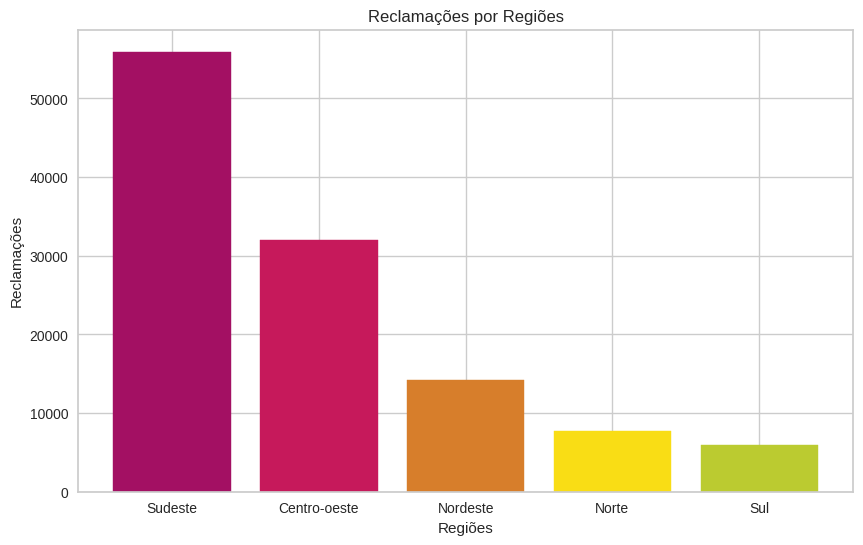

In [ ]:
# Plot do gráfico de barras por região, quantidade de reclamações e ordenado por reclamações
plt.figure(figsize=(10, 6))


region_custom_colors = {
    'Sudeste': '#a31063',
    'Centro-oeste': '#c6195b',
    'Nordeste': '#d77e2b',
    'Norte': '#f9dd15',
    'Sul': '#bbcb30',
}
axs = plt.bar(df_reclamacoes_regiao['Regiao'], df_reclamacoes_regiao['Reclamacoes'])
plt.xlabel('Regiões')
plt.ylabel('Reclamações')
plt.title('Reclamações por Regiões')
for i, bar in enumerate(axs):
    bar.set_color(region_custom_colors[df_reclamacoes_regiao['Regiao'][i]])
plt.show()

### c.2 E de acordo com o estado?

In [ ]:
# Agrupamento por estado, quantidade de reclamações e ordenado por reclamações
df_reclamacoes_estado = combined_df.groupby(['Regiao', 'UF'])['UF'].count().sort_values(ascending=False).reset_index(name='Reclamacoes')
df_reclamacoes_estado

,Regiao,UF,Reclamacoes
0,Sudeste,SP,40998
1,Centro-oeste,GO,17259
2,Sudeste,MG,8550
3,Nordeste,RN,8128
4,Centro-oeste,MT,7822
5,Centro-oeste,MS,6972
6,Norte,RO,6195
7,Sul,SC,4920
8,Sudeste,RJ,3612
9,Sudeste,ES,2781


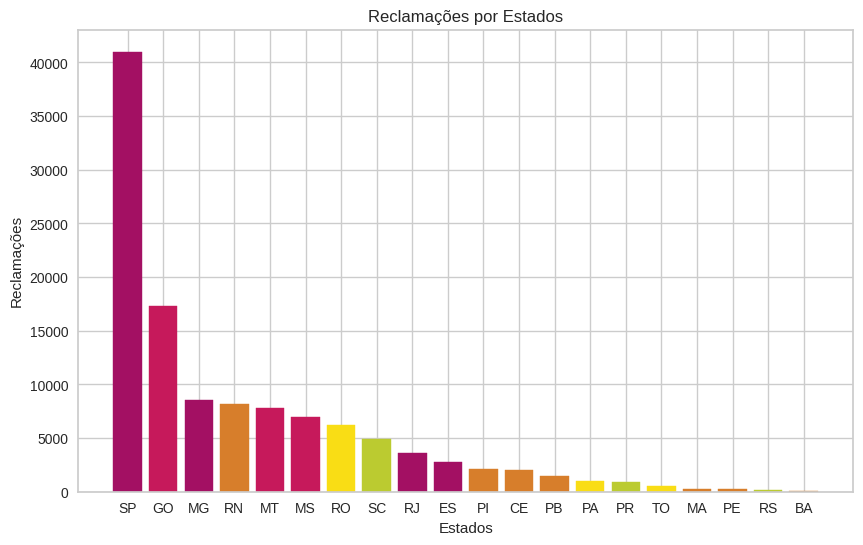

In [ ]:
# Plot do gráfico de barras das reclamações por estado, quantidade de reclamações e ordenado por reclamações
plt.figure(figsize=(10, 6))
axs = plt.bar(df_reclamacoes_estado['UF'], df_reclamacoes_estado['Reclamacoes'])
plt.xlabel('Estados')
plt.ylabel('Reclamações')
plt.title('Reclamações por Estados')
for i, bar in enumerate(axs):
    bar.set_color(region_custom_colors[df_reclamacoes_estado['Regiao'][i]])
plt.show()

### c.3 E se ponderarmos pela população média do estado?

In [ ]:
# Importação dos dados do Censo
df_censo_2022 = pd.read_excel('censo2022.xlsx', sheet_name='Tabela_Formatada')
# Tratamento dos dados
# Remover colunas não utilizadas
df_censo_2022.drop(['Cód.', 'Nível', 'Brasil, Grande Região e Unidade da Federação'], axis=1, inplace=True)
novas_colunas = {
    '2022': 'Populacao'
}
# Renomear colunas
df_censo_2022.rename(columns=novas_colunas, inplace=True)

In [ ]:
# Agrupamento por região, estado, quantidade de reclamações e ordenado por reclamações
df_reclamacoes_regiao_estado = combined_df.groupby(['Regiao', 'UF'])['UF'].count().sort_values(ascending=False).reset_index(name='Reclamacoes')

# Merge dos DataFrames Reclamações por Estado e Censo 2022
df_reclamacoes_estado_censo = pd.merge(df_censo_2022, df_reclamacoes_regiao_estado, on='UF')

# Média ponderada com a população extraída de cada estado
df_reclamacoes_estado_censo['MediaPonderadaReclamacoes'] = (df_reclamacoes_estado_censo['Reclamacoes'] * df_reclamacoes_estado_censo['Populacao']) / df_reclamacoes_estado_censo['Populacao'].sum()
df_reclamacoes_estado_censo

,UF,Populacao,Regiao,Reclamacoes,MediaPonderadaReclamacoes
0,RO,1581196,Norte,6195,51.887503
1,PA,8120131,Norte,987,42.453739
2,TO,1511460,Norte,567,4.539578
3,MA,6776699,Nordeste,216,7.753677
4,PI,3271199,Nordeste,2153,37.306693
5,CE,8794957,Nordeste,1982,92.336440
6,RN,3302729,Nordeste,8128,142.197641
7,PB,3974687,Nordeste,1486,31.286537
8,PE,9058931,Nordeste,211,10.125003
9,BA,14141626,Nordeste,25,1.872730


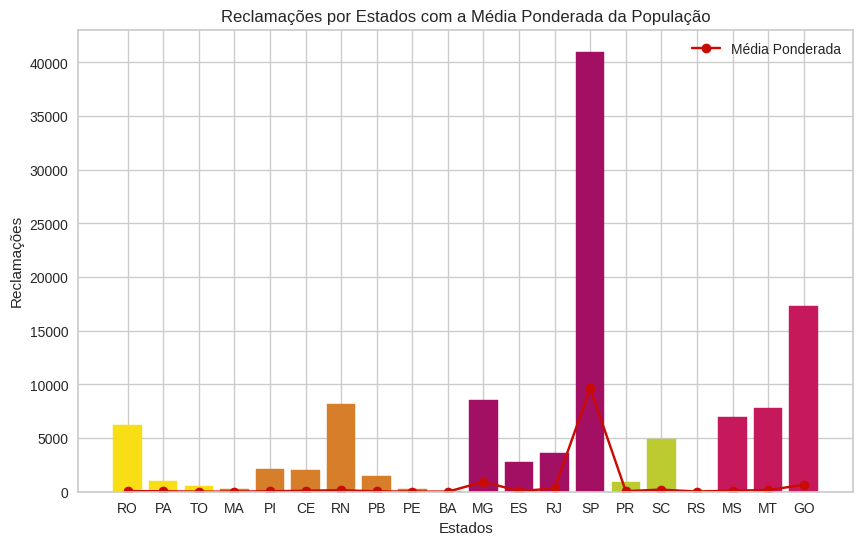

In [ ]:
#Plotagem de gráfico de barras para verificar as reclamações por estados em
#comparação a média ponderada da população obtida pelo censo 2022

plt.figure(figsize=(10, 6))
plt.bar(df_reclamacoes_estado_censo['UF'],
        df_reclamacoes_estado_censo['Reclamacoes'])
axs = plt.bar(df_reclamacoes_estado_censo['UF'],
              df_reclamacoes_estado_censo['Reclamacoes'])
for i, bar in enumerate(axs):
    bar.set_color(region_custom_colors[df_reclamacoes_estado_censo['Regiao'][i]])
plt.plot(df_reclamacoes_estado_censo['UF'],
         df_reclamacoes_estado_censo['MediaPonderadaReclamacoes'],
         marker='o', color='r', label = 'Média Ponderada')
plt.xlabel('Estados')
plt.ylabel('Reclamações')
plt.title('Reclamações por Estados com a Média Ponderada da População')
plt.legend()
plt.show()

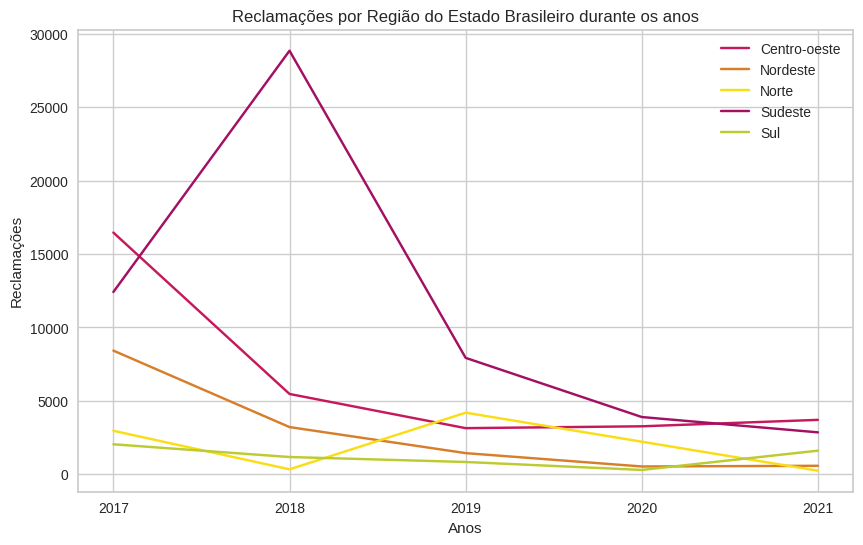

In [ ]:
# Realizar gráfico de reclamação por região ao longo dos anos
# Agrupamento por região, ano calendário, com a quantidade de reclamações e ordenado por reclamações
df_reclamacoes_regiao_ano = combined_df.groupby(['Regiao', 'AnoCalendario'])['AnoCalendario'].count().reset_index(name='Reclamacoes')

# Ordenado por região e ano calendário
df_reclamacoes_regiao_ano.sort_values(['Regiao', 'AnoCalendario'])
plt.figure(figsize=(10, 6))

# Percorrer o DataSet, utilizado cada região, que formarão as linhas do gráfico
for regiao in df_reclamacoes_regiao_ano['Regiao'].unique():
  plt.plot(df_reclamacoes_regiao_ano[df_reclamacoes_regiao_ano['Regiao'] == regiao]['AnoCalendario'].astype(str), df_reclamacoes_regiao_ano[df_reclamacoes_regiao_ano['Regiao'] == regiao]['Reclamacoes'], label = regiao)
for ax in plt.gcf().axes:
  for line in ax.get_lines():
    line.set_color(region_custom_colors[line.get_label()])

plt.legend()
plt.title('Reclamações por Região do Estado Brasileiro durante os anos')
plt.xlabel('Anos')
plt.ylabel('Reclamações')
plt.show()

###d.1 Quais as empresas que receberam mais reclamações dos consumidores?

strRazaoSocial
CLARO S/A                                            2090
TELEFONICA BRASIL S/A                                2081
TIM CELULAR S/A                                      1940
ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO    1496
CNOVA COMERCIO ELETRONICO S/A                        1405
VIA VAREJO S/A                                       1205
LKD COMERCIO ELETRONICO S/A - LOJASKD                1003
CAIXA ECONOMICA FEDERAL                               932
ZURICH MINAS BRASIL SEGUROS S/A                       911
CAIXA ECONÔMICA FEDERAL                               866
Name: strRazaoSocial, dtype: int64


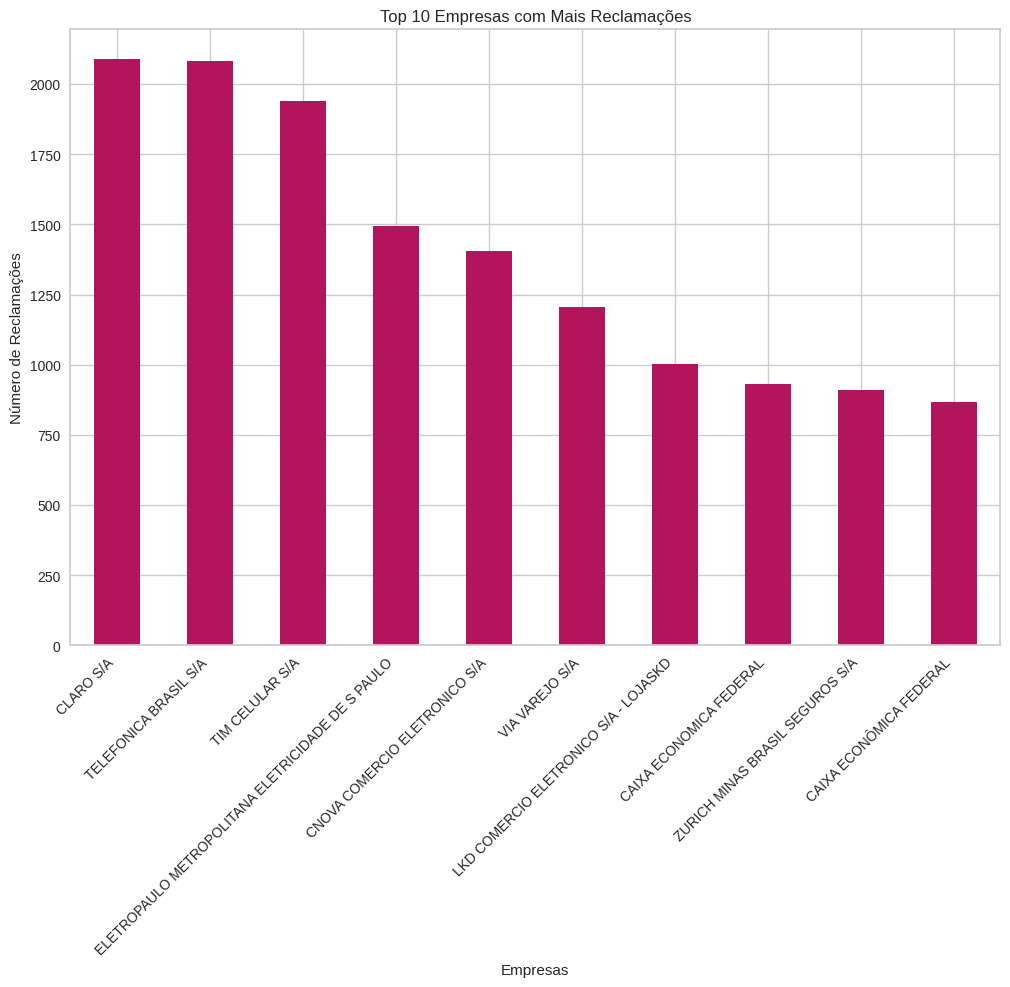

In [ ]:
# Agrupamento por Empresas (Razão Social), com a quantidade de reclamações e ordenado por reclamações
df_reclamacoes_empresas = combined_df.groupby('strRazaoSocial')['strRazaoSocial'].count().sort_values(ascending=False)
df_reclamacoes_empresas

# Total de reclamações por empresa (mantendo a estrutura original)
df_reclamacoes_empresas_top10 = df_reclamacoes_empresas.head(10)
print(df_reclamacoes_empresas_top10)

# Gráfico de barras das empresas com mais reclamações
plt.figure(figsize=(12, 8))
df_reclamacoes_empresas_top10.plot(kind='bar', color='#b2155c')
plt.title('Top 10 Empresas com Mais Reclamações')
plt.xlabel('Empresas')
plt.ylabel('Número de Reclamações')
plt.xticks(rotation=45, ha='right')
plt.show()


###d.2 E por estado?

<ipython-input-32-e1a0ad4a0cee>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_estado, x='counts', y='strRazaoSocial', ax=ax, palette=cores[:len(data_estado)])
<ipython-input-32-e1a0ad4a0cee>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_estado, x='counts', y='strRazaoSocial', ax=ax, palette=cores[:len(data_estado)])
<ipython-input-32-e1a0ad4a0cee>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_estado, x='counts', y='strRazaoSocial', ax=ax, palette=cores[:len(data_estado)])
<ipython-input-32-e1a0ad4a0c

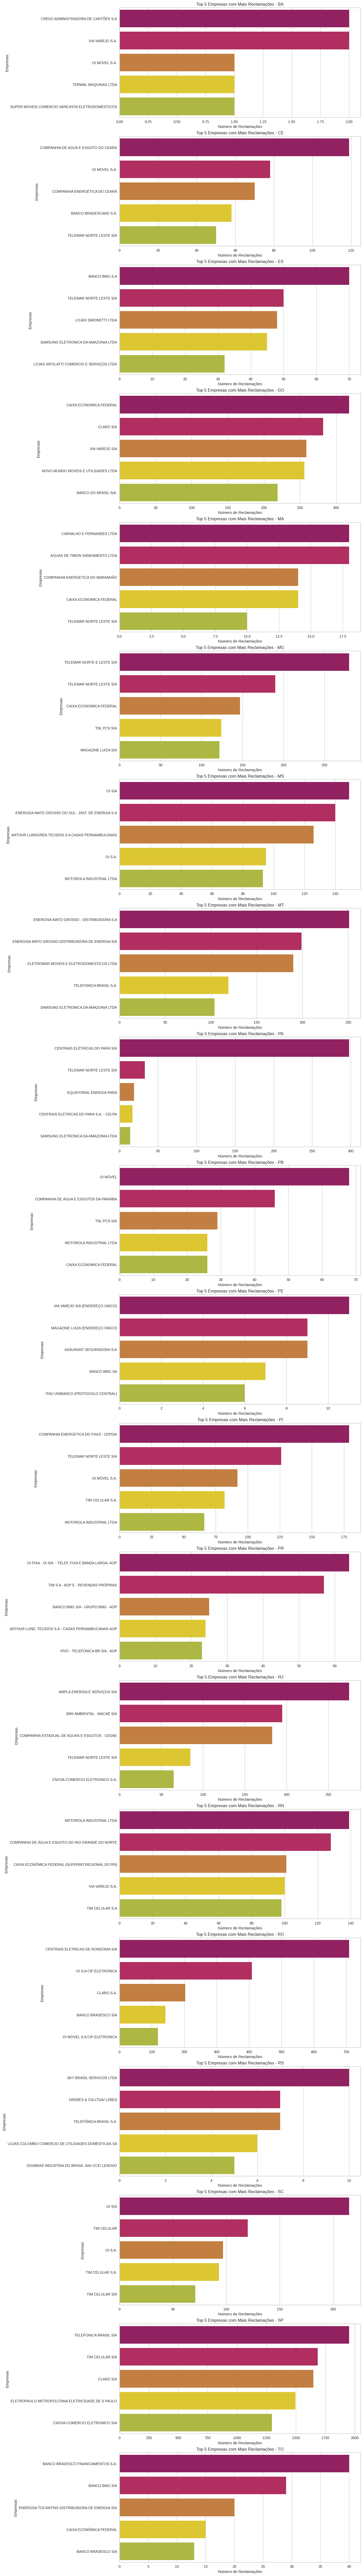

In [ ]:
# Agrupamento por Empresas (Razão Social), estado, com a quantidade de reclamações e ordenado por reclamações
df_reclamacoes_empresas_estado = combined_df.groupby(['strRazaoSocial', 'UF'])['strRazaoSocial'].count().sort_values(ascending=False)
df_reclamacoes_empresas_estado


# Conversão para DataFrame para facilitar a manipulação
df_reclamacoes_empresas_estado = df_reclamacoes_empresas_estado.reset_index(name='counts')

# Seleção das 5 empresas com mais reclamações por estado
df_reclamacoes_empresas_estado_top5 = df_reclamacoes_empresas_estado.groupby('UF').apply(lambda x: x.nlargest(5, 'counts')).reset_index(drop=True)

# Criar gráficos separados para cada estado
estados = df_reclamacoes_empresas_estado_top5['UF'].unique()
num_estados = len(estados)
fig, axes = plt.subplots(nrows=num_estados, ncols=1, figsize=(14, 5 * num_estados), constrained_layout=True)

# Lista de cores para usar
cores = ['#a31063', '#c6195b', '#d77e2b', '#f9dd15', '#bbcb30']

for ax, estado in zip(axes, estados):
    data_estado = df_reclamacoes_empresas_estado_top5[df_reclamacoes_empresas_estado_top5['UF'] == estado]
    sns.barplot(data=data_estado, x='counts', y='strRazaoSocial', ax=ax, palette=cores[:len(data_estado)])
    ax.set_title(f'Top 5 Empresas com Mais Reclamações - {estado}')
    ax.set_xlabel('Número de Reclamações')
    ax.set_ylabel('Empresas')

plt.show()


In [ ]:
# Agrupamento por CNAE, com a quantidade de reclamações e ordenado por reclamações
df_reclamacoes_cnae = combined_df.groupby('DescCNAEPrincipal')['DescCNAEPrincipal'].count().sort_values(ascending=False).reset_index(name='Reclamacoes')

# Removidos NAN
df_reclamacoes_cnae['DescCNAEPrincipal'].dropna()

# Visualização dos TOP 10
df_reclamacoes_cnae[:10]

,DescCNAEPrincipal,Reclamacoes
0,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",10595
1,TELEFONIA MÓVEL CELULAR,7644
2,SERVIÇOS DE TELEFONIA FIXA COMUTADA - STFC,6086
3,DISTRIBUIÇÃO DE ENERGIA ELÉTRICA,4847
4,COMÉRCIO VAREJISTA ESPECIALIZADO DE ELETRODOMÉ...,4283
5,SEGUROS DE VIDA,2593
6,COMÉRCIO VAREJISTA DE MÓVEIS,2467
7,CAIXAS ECONÔMICAS,2229
8,SEGUROS NÃO-VIDA,2216
9,"SOCIEDADES DE CRÉDITO, FINANCIAMENTO E INVESTI...",2121


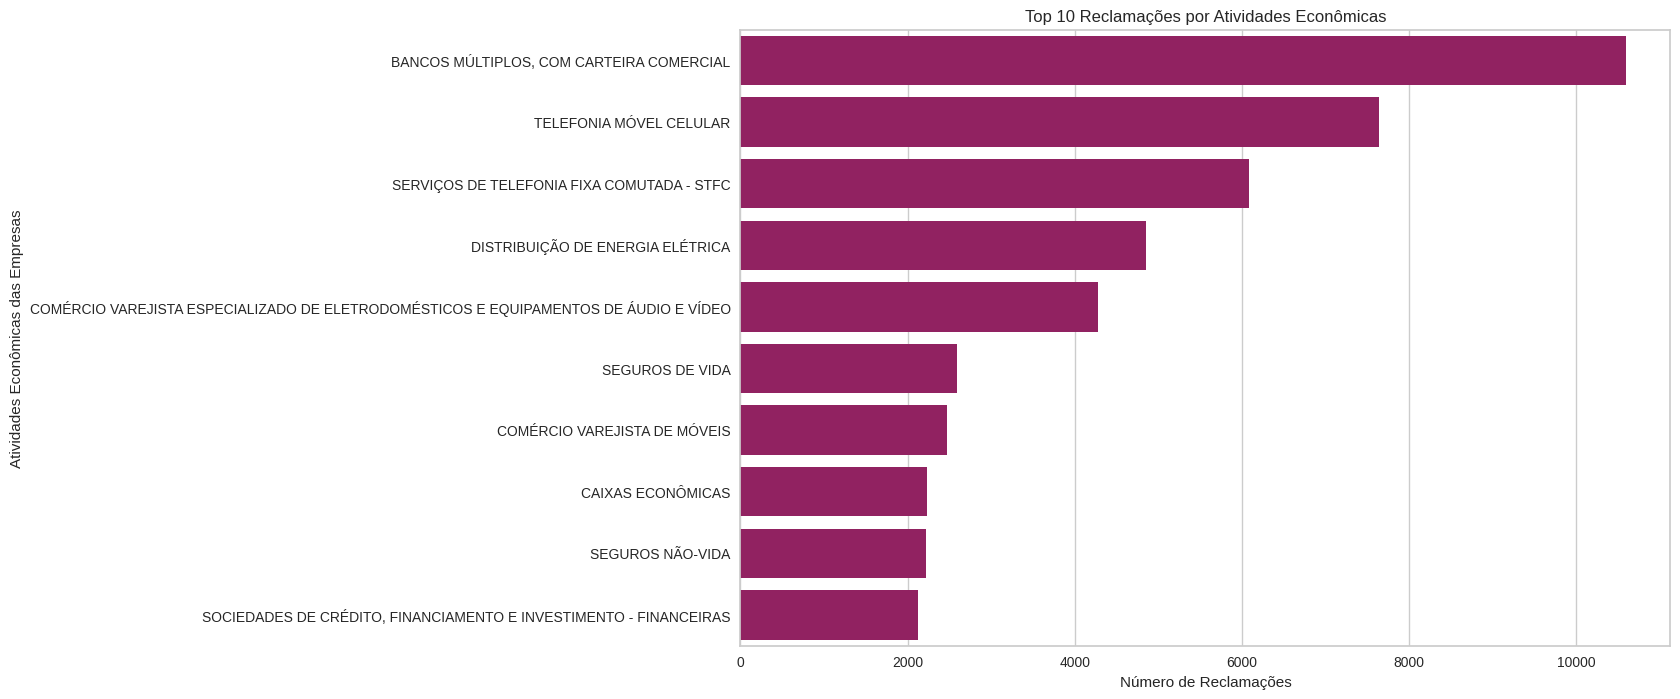

In [ ]:
# Plot por CNAE, com a quantidade de reclamações e ordenado por reclamações
plt.figure(figsize=(12, 8))
sns.barplot(data=df_reclamacoes_cnae[:10], x='Reclamacoes', y='DescCNAEPrincipal', dodge=False, color= '#a31063')
plt.title('Top 10 Reclamações por Atividades Econômicas')
plt.xlabel('Número de Reclamações')
plt.ylabel('Atividades Econômicas das Empresas')
plt.show()

###d.3 E por região?

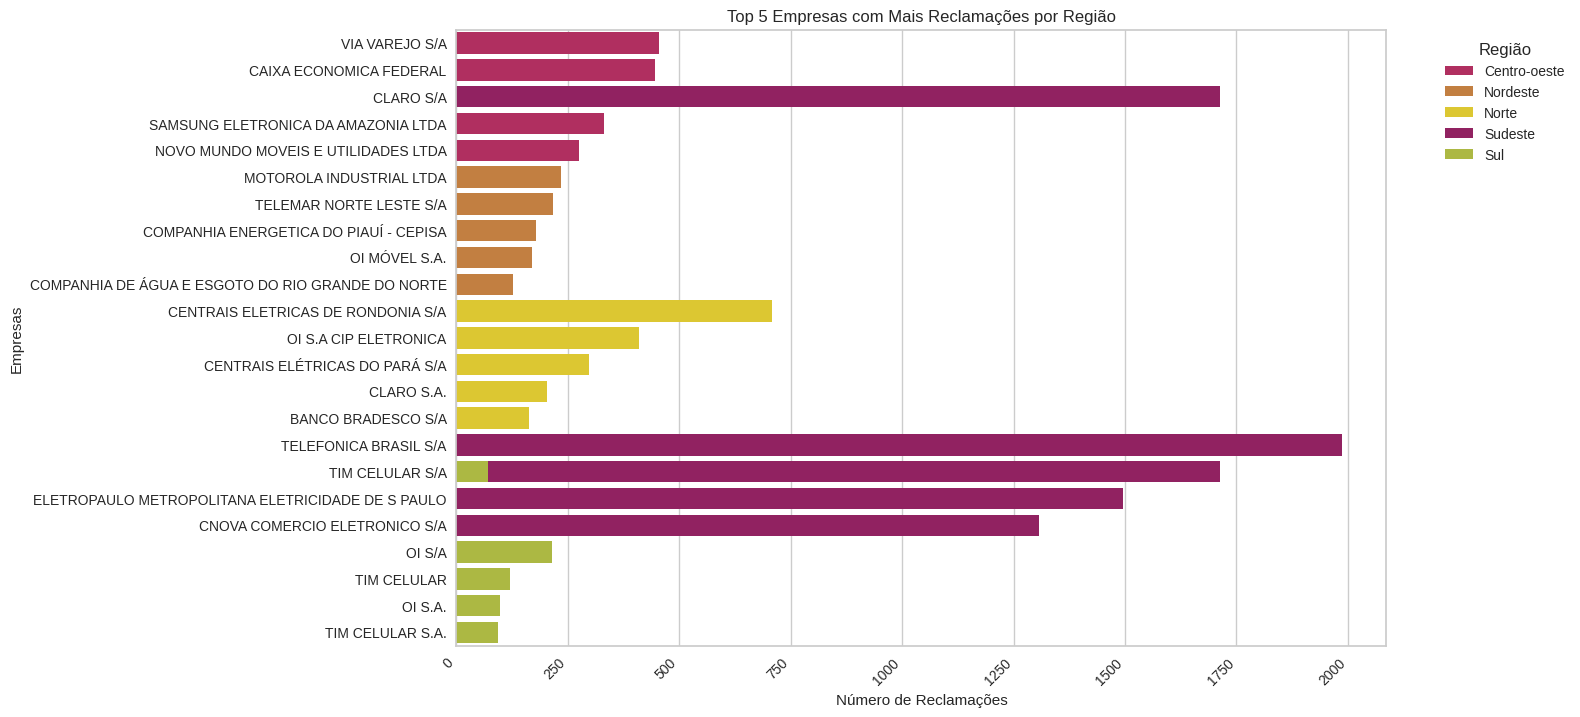

In [ ]:
# Agrupamento por Empresas (Razão Social), regiões, com a quantidade de reclamações e ordenado por reclamações
df_reclamacoes_empresas_regiao = combined_df.groupby(['strRazaoSocial', 'Regiao'])['strRazaoSocial'].count().sort_values(ascending=False)
df_reclamacoes_empresas_regiao

# Conversão para DataFrame para facilitar a manipulação
df_reclamacoes_empresas_regiao = df_reclamacoes_empresas_regiao.reset_index(name='counts')

# Seleção das 5 empresas com mais reclamações por região
df_reclamacoes_empresas_regiao_top5 = df_reclamacoes_empresas_regiao.groupby('Regiao').apply(lambda x: x.nlargest(5, 'counts')).reset_index(drop=True)

# Definindo a paleta de cores personalizada com base no dicionário
region_custom_colors = {
    'Sudeste': '#a31063',
    'Centro-oeste': '#c6195b',
    'Nordeste': '#d77e2b',
    'Norte': '#f9dd15',
    'Sul': '#bbcb30',
}

# Criando uma paleta de cores para Seaborn a partir do dicionário
custom_palette = [region_custom_colors[regiao] for regiao in df_reclamacoes_empresas_regiao_top5['Regiao'].unique()]

# Gráfico de barras das empresas com mais reclamações por região
plt.figure(figsize=(12, 8))
sns.barplot(data=df_reclamacoes_empresas_regiao_top5, x='counts', y='strRazaoSocial', hue='Regiao', dodge=False, palette=custom_palette)
plt.title('Top 5 Empresas com Mais Reclamações por Região')
plt.xlabel('Número de Reclamações')
plt.ylabel('Empresas')
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

## 2) Modelagem: Prevendo o tempo de uma reclamação ativa

O time de negócios gostaria que a sua equipe fizesse um modelo de regressão para estimar qual será o tempo médio de uma reclamação ativa.

###a. Quais variáveis podem estar mais correlacionadas com o tempo de uma reclamação ativa?

###b. Construa variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa a partir dos dados: Exemplo: crie variáveis dummy referentes ao período do ano ; região



In [ ]:
# Criei uma cópia do dataframe para inserir os tratamentos de dados - Eduarda
df_tratado = combined_df.copy()

In [ ]:
combined_df.head(2)

,AnoCalendario,DataArquivamento,DataAbertura,CodigoRegiao,Regiao,UF,strRazaoSocial,strNomeFantasia,Tipo,NumeroCNPJ,RadicalCNPJ,RazaoSocialRFB,NomeFantasiaRFB,CNAEPrincipal,DescCNAEPrincipal,Atendida,CodigoAssunto,DescricaoAssunto,CodigoProblema,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,CEPConsumidor,DiferencaTempo,DiferencaTempoNum,MesAbertura
0,2017,2017-12-12 12:35:53,2017-07-31 16:03:45,3,Sudeste,SP,CLARO S/A,NET,1,4.043254e+13,40432544.0,NaN,NaN,NaN,NaN,S,186.0,Telefonia Fixa ( Plano de Expansão / Compra e ...,3844.0,Contrato - Rescisão/alteração unilateral,M,mais de 70 anos,4444000.0,133 days 20:32:08,133.0,7.0
1,2017,2017-12-12 12:40:07,2017-08-04 10:55:48,3,Sudeste,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,ELETROPAULO METROPOLITANA,1,6.169523e+13,61695227.0,ELETROPAULO METROPOLITANA ELETRICIDADE DE SAO ...,ELETROPAULO METROPOLITANA,3514000.0,DISTRIBUIÇÃO DE ENERGIA ELÉTRICA,N,185.0,Energia Elétrica,6030.0,PID - Pedido de Indenização por Danos Morais,F,entre 31 a 40 anos,4674110.0,130 days 01:44:19,130.0,8.0


In [ ]:
# Verifica os valores dos registros para sexo. Como os valores N e NaN representam menos de 1% do dataframe serão excluídos.
df_tratado = df_tratado[(df_tratado['SexoConsumidor'] == 'F') | (df_tratado['SexoConsumidor'] == 'M')]
df_tratado['SexoConsumidor'].value_counts(normalize = True, dropna = False) * 100

SexoConsumidor
F    52.470744
M    47.529256
Name: proportion, dtype: float64

In [ ]:
#A coluna ATENDIDA retornava S e N, portanto gerará a dummy.
def coluna_dummy(coluna, df_list):
    for dataframe in df_list:
        dataframe[coluna] = dataframe[coluna].map({'S': 1, 'N': 0})
        print(f"Coluna dummy criada com sucesso nos anos de {dataframe['AnoCalendario'].unique()}")

# Aplica a função
coluna_dummy('Atendida', [df_tratado])

Coluna dummy criada com sucesso nos anos de [2017 2018 2019 2020 2021]


In [ ]:
# Alterando a coluna SexoConsumidor para valor binário 0/1
df_tratado['SexoConsumidor'] = df_tratado['SexoConsumidor'].replace({'M': 1, 'F': 0}).astype(int)

# Aplicando One-hot-Encoding para a coluna de faixa etaria
df_tratado = pd.get_dummies(df_tratado, columns = ['FaixaEtariaConsumidor'], dtype = float)

# Aplicando One-hot-Encoding para a coluna de região
df_tratado = pd.get_dummies(df_tratado, columns = ['Regiao'], dtype = float)

# Aplicando One-hot-Encoding para a coluna estado
df_tratado = pd.get_dummies(df_tratado, columns = ['UF'], dtype = float)

In [ ]:
# Remove colunas não-numéricas ou que aparecem a mesma informação de forma numérica
df_tratado.drop(columns = ['DataArquivamento', 'DataAbertura', 'CodigoRegiao',
                           'NumeroCNPJ', 'strRazaoSocial', 'strNomeFantasia', 'RadicalCNPJ',
                           'RazaoSocialRFB', 'NomeFantasiaRFB', 'DescCNAEPrincipal',
                           'DescricaoAssunto', 'DescricaoProblema', 'DiferencaTempo'], axis = 1, inplace = True)

In [ ]:
df_tratado.head(2)

,AnoCalendario,Tipo,CNAEPrincipal,Atendida,CodigoAssunto,CodigoProblema,SexoConsumidor,CEPConsumidor,DiferencaTempoNum,MesAbertura,FaixaEtariaConsumidor_Nao Informada,FaixaEtariaConsumidor_até 20 anos,FaixaEtariaConsumidor_entre 21 a 30 anos,FaixaEtariaConsumidor_entre 31 a 40 anos,FaixaEtariaConsumidor_entre 41 a 50 anos,FaixaEtariaConsumidor_entre 51 a 60 anos,FaixaEtariaConsumidor_entre 61 a 70 anos,FaixaEtariaConsumidor_mais de 70 anos,Regiao_Centro-oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste,Regiao_Sul,UF_BA,UF_CE,UF_ES,UF_GO,UF_MA,UF_MG,UF_MS,UF_MT,UF_PA,UF_PB,UF_PE,UF_PI,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RS,UF_SC,UF_SP,UF_TO
0,2017,1,NaN,1,186.0,3844.0,1,4444000.0,133.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2017,1,3514000.0,0,185.0,6030.0,0,4674110.0,130.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Verificando o formato dos dados
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114763 entries, 0 to 115920
Data columns (total 43 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   AnoCalendario                             114763 non-null  int64  
 1   Tipo                                      114763 non-null  int64  
 2   CNAEPrincipal                             99357 non-null   float64
 3   Atendida                                  114763 non-null  int64  
 4   CodigoAssunto                             114749 non-null  float64
 5   CodigoProblema                            49738 non-null   float64
 6   SexoConsumidor                            114763 non-null  int64  
 7   CEPConsumidor                             102488 non-null  float64
 8   DiferencaTempoNum                         114750 non-null  float64
 9   MesAbertura                               114763 non-null  float64
 10  FaixaEtariaConsumidor_Nao

### c. Analise a correlação das variáveis

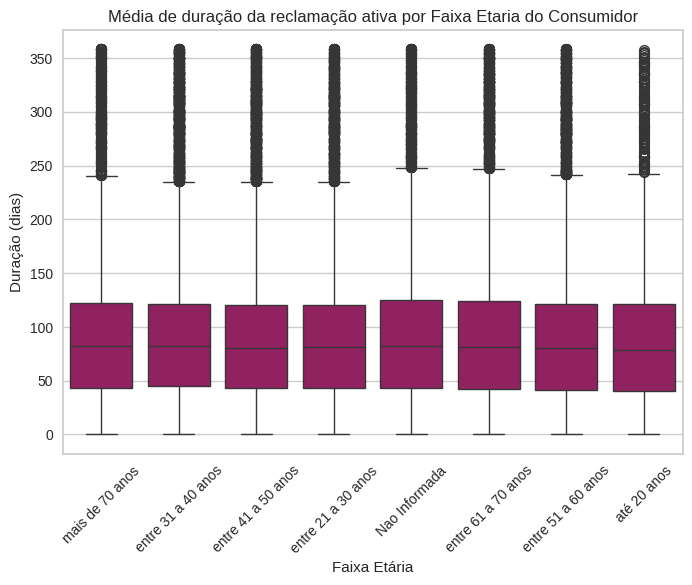

In [ ]:
# Boxplot para avaliar as diferentes faixas etárias pelo tempo de reclamação ativa
sns.boxplot(df_sem_outlier, x = 'FaixaEtariaConsumidor', y = 'DiferencaTempoNum', color= '#a31063');
plt.title('Média de duração da reclamação ativa por Faixa Etaria do Consumidor')
plt.xlabel('Faixa Etária')
plt.ylabel('Duração (dias)')
plt.xticks(rotation= 45)
plt.show();

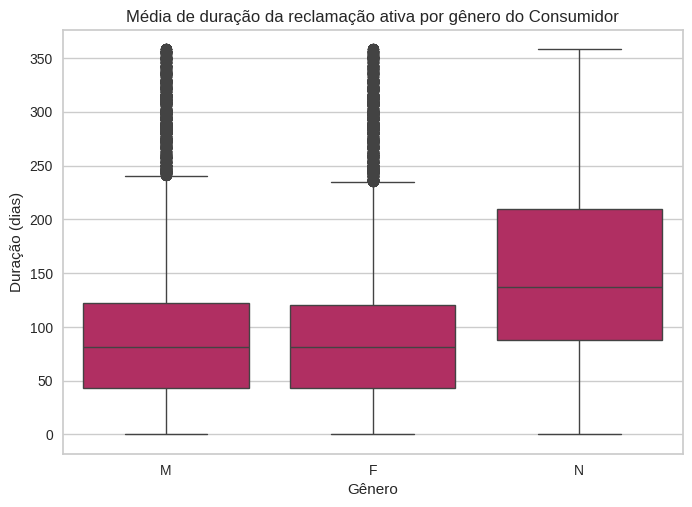

In [ ]:
sns.boxplot(df_sem_outlier, x = 'SexoConsumidor', y = 'DiferencaTempoNum', color= '#c6195d')

plt.title('Média de duração da reclamação ativa por gênero do Consumidor')
plt.xlabel('Gênero')
plt.ylabel('Duração (dias)')
plt.xticks(rotation = 0)
plt.show();

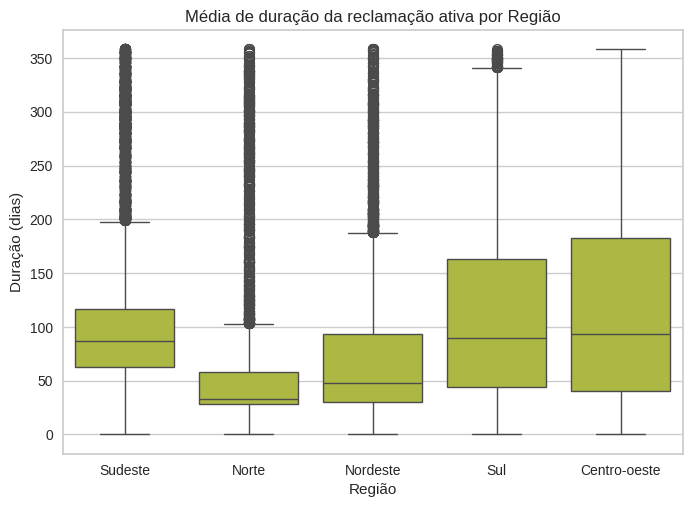

In [ ]:
sns.boxplot(df_sem_outlier, x = 'Regiao', y = 'DiferencaTempoNum', color= '#bbcb30')

plt.title('Média de duração da reclamação ativa por Região')
plt.xlabel('Região')
plt.ylabel('Duração (dias)')
plt.xticks(rotation = 0)
plt.show();

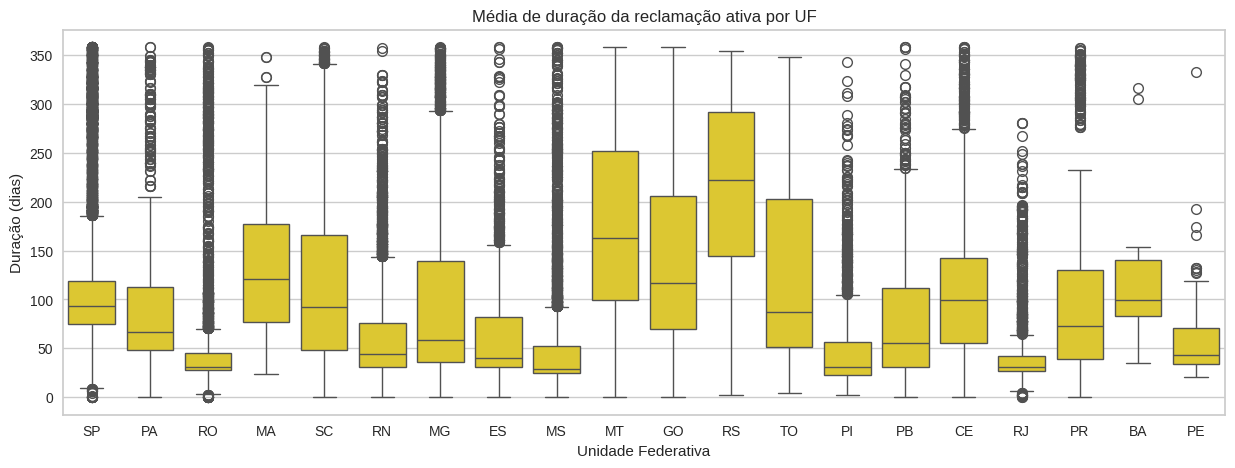

In [ ]:
plt.figure(figsize = (15,5))
sns.boxplot(df_sem_outlier, x = 'UF', y = 'DiferencaTempoNum', color= '#f9dd15')

plt.title('Média de duração da reclamação ativa por UF')
plt.xlabel('Unidade Federativa')
plt.ylabel('Duração (dias)')
plt.xticks(rotation = 0)
plt.show();

In [ ]:
# Filtra o df_tratado para analisar a correlação "em partes"

df_tratado_nao_dummies = df_tratado[['AnoCalendario', 'Tipo', 'CNAEPrincipal', 'Atendida', 'CodigoAssunto', 'CodigoProblema', 'SexoConsumidor', 'CEPConsumidor', 'DiferencaTempoNum']]

df_tratado_idade = df_tratado[['FaixaEtariaConsumidor_Nao Informada',
                                'FaixaEtariaConsumidor_até 20 anos',
                                'FaixaEtariaConsumidor_entre 21 a 30 anos',
                                'FaixaEtariaConsumidor_entre 31 a 40 anos',
                                'FaixaEtariaConsumidor_entre 41 a 50 anos',
                                'FaixaEtariaConsumidor_entre 51 a 60 anos',
                                'FaixaEtariaConsumidor_entre 61 a 70 anos',
                                'FaixaEtariaConsumidor_mais de 70 anos', 'DiferencaTempoNum']]

df_tratado_regiao = df_tratado[['Regiao_Centro-oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul', 'DiferencaTempoNum']]

df_tratado_estados = df_tratado[['UF_BA', 'UF_CE', 'UF_ES', 'UF_GO', 'UF_MA', 'UF_MG', 'UF_MS', 'UF_MT', 'UF_PA', 'UF_PB', 'UF_PE', 'UF_PI', 'UF_PR', 'UF_RJ', 'UF_RN', 'UF_RO', 'UF_RS', 'UF_SC', 'UF_SP', 'UF_TO', 'DiferencaTempoNum']]

lista_df = [df_tratado_nao_dummies, df_tratado_idade, df_tratado_regiao]

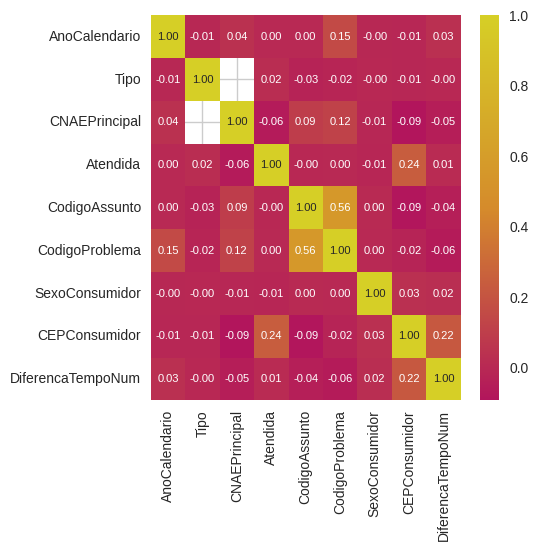

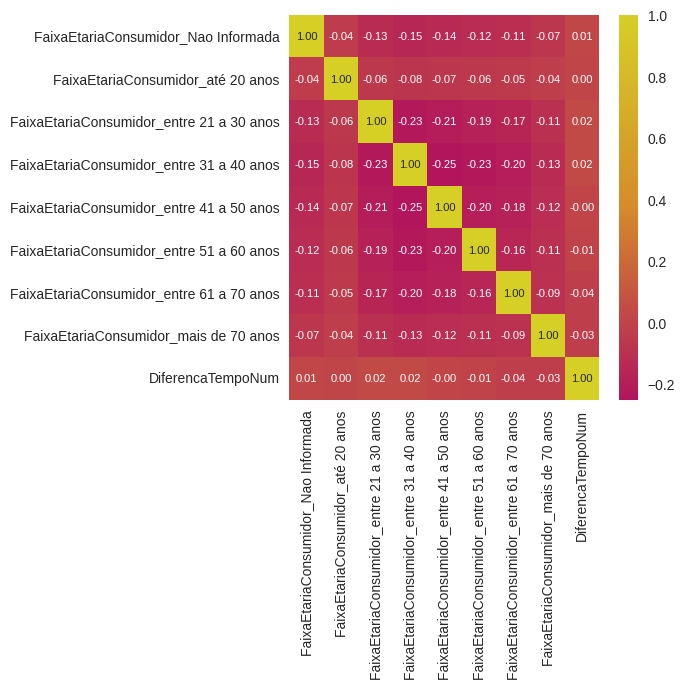

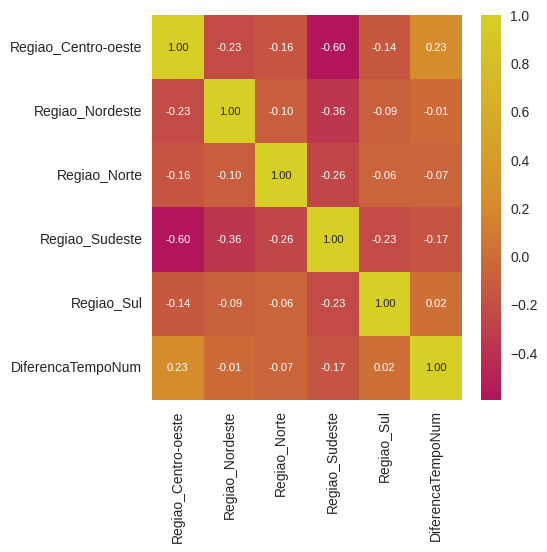

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#b2155c', '#d58b2b', '#d6cf26']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

for dataframe in lista_df:
    corr = dataframe.corr()
    plt.figure(figsize=(5, 5))
    sns.heatmap(corr, annot=True, annot_kws={"size": 8}, fmt='.2f', cmap=custom_cmap)

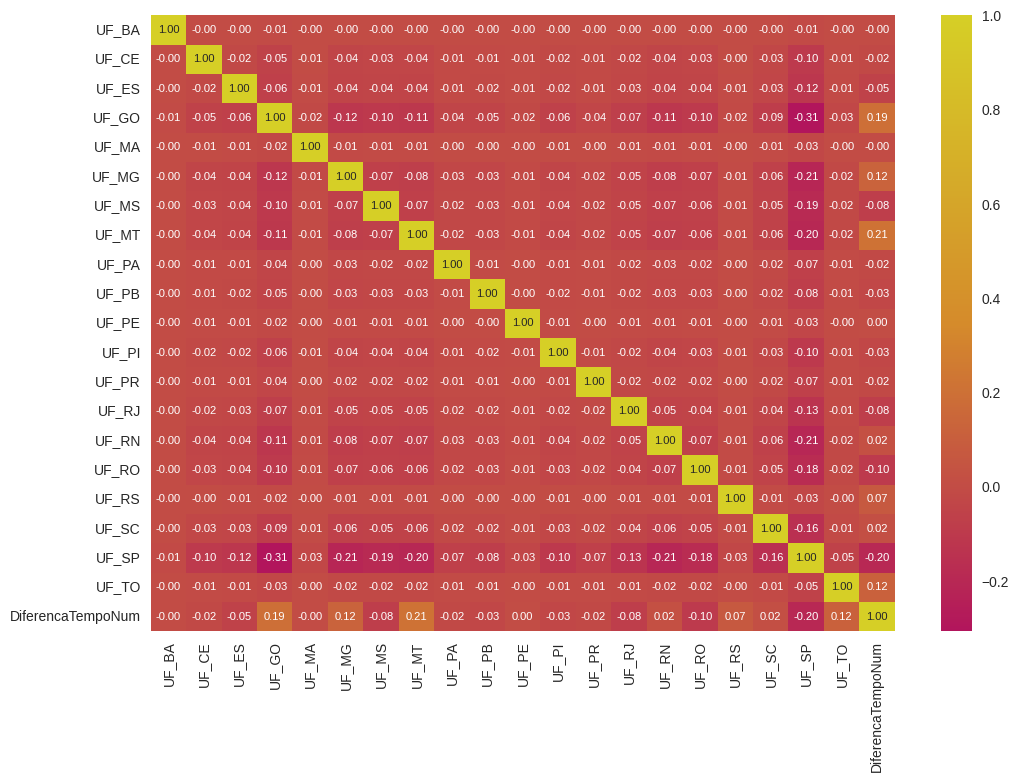

In [ ]:
  #Heatmap da correlação do dataframe dos estados x tempo de duração da reclamação ativa
  corr1 = df_tratado_estados.corr()
  plt.figure(figsize = (12, 8))
  sns.heatmap(corr1, annot = True, annot_kws={"size": 8}, fmt='.2f', cmap=custom_cmap);

### d. Construa um modelo de regressão linear em que queremos estimar o tempo de uma reclamação ativa.

In [ ]:
#validando se ficou algum nulo de variáveis que podem ser utilizadas como independentes
print(df_tratado.isnull().sum())

AnoCalendario                                   0
Tipo                                            0
CNAEPrincipal                               15406
Atendida                                        0
CodigoAssunto                                  14
CodigoProblema                              65025
SexoConsumidor                                  0
CEPConsumidor                               12275
DiferencaTempoNum                              13
MesAbertura                                     0
FaixaEtariaConsumidor_Nao Informada             0
FaixaEtariaConsumidor_até 20 anos               0
FaixaEtariaConsumidor_entre 21 a 30 anos        0
FaixaEtariaConsumidor_entre 31 a 40 anos        0
FaixaEtariaConsumidor_entre 41 a 50 anos        0
FaixaEtariaConsumidor_entre 51 a 60 anos        0
FaixaEtariaConsumidor_entre 61 a 70 anos        0
FaixaEtariaConsumidor_mais de 70 anos           0
Regiao_Centro-oeste                             0
Regiao_Nordeste                                 0


A variável Código do problema não é uma boa variável para levar para o modelo de regressão uma vez que mais de 50% dos valores estão ausentes.

In [ ]:
# Cria uma cópia do dataframe df_tratado e exlcui a coluna Código Problema que possui muitos valores ausentes
df_lr = df_tratado.copy()
df_lr.drop(columns = ['AnoCalendario'], inplace = True)
df_lr.drop(columns = ['CodigoProblema'], inplace = True)

In [ ]:
# Exclui os registros que possuem valores ausentes de acordo com a coluna
df_lr.dropna(subset = ['CodigoAssunto'], inplace = True)
df_lr.dropna(subset = ['DiferencaTempoNum'], inplace = True)

In [ ]:
(df_lr.isnull().sum() / df_lr.shape[0] * 100).round(2)

Tipo                                         0.00
CNAEPrincipal                               13.43
Atendida                                     0.00
CodigoAssunto                                0.00
SexoConsumidor                               0.00
CEPConsumidor                               10.70
DiferencaTempoNum                            0.00
MesAbertura                                  0.00
FaixaEtariaConsumidor_Nao Informada          0.00
FaixaEtariaConsumidor_até 20 anos            0.00
FaixaEtariaConsumidor_entre 21 a 30 anos     0.00
FaixaEtariaConsumidor_entre 31 a 40 anos     0.00
FaixaEtariaConsumidor_entre 41 a 50 anos     0.00
FaixaEtariaConsumidor_entre 51 a 60 anos     0.00
FaixaEtariaConsumidor_entre 61 a 70 anos     0.00
FaixaEtariaConsumidor_mais de 70 anos        0.00
Regiao_Centro-oeste                          0.00
Regiao_Nordeste                              0.00
Regiao_Norte                                 0.00
Regiao_Sudeste                               0.00


Restaram somente duas colunas com valores ausentes, todavia elas representam mais de 10% dos registros. Levando em consideração que a variável CEPConsumidor possui uma correlação fraca (0.22) com  a variável de interesse, vamos efetuar a exclusão dos registros ausentes, já a variável CNAEPrincipal vamos excluir do modelo.

In [ ]:
df_lr.dropna(subset = ['CEPConsumidor'], inplace = True)

df_lr.drop(columns = ['CNAEPrincipal'], inplace = True)

In [ ]:
# Dimensões do dataframe após as manipulações
df_lr.shape

(102461, 40)

In [ ]:
X = df_lr.copy()
X.drop(columns = ['DiferencaTempoNum'], inplace = True)
y = df_lr['DiferencaTempoNum']


In [ ]:
X.shape, y.shape

((102461, 39), (102461,))

In [ ]:
#Exibir o sumário detalhado do modelo de regressão linear múltipla
import statsmodels.api as sm

#adicionando um constante de intercepto ao modelo
X = sm.add_constant(X)

#criar o modelo de regressão linear
model = sm.OLS(y, X).fit()

#imprimir o sumário do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      DiferencaTempoNum   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     617.5
Date:                Fri, 26 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:48:21   Log-Likelihood:            -7.3238e+05
No. Observations:              102461   AIC:                         1.465e+06
Df Residuals:                  102428   BIC:                         1.465e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

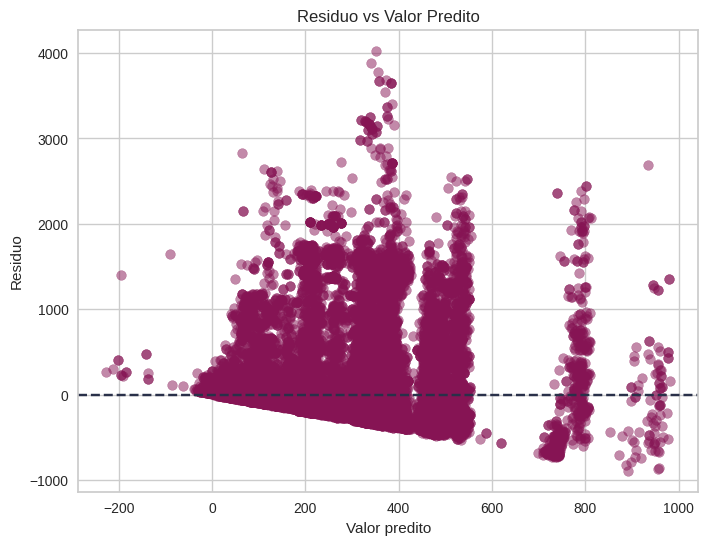

In [ ]:
# Salvamos os dados dos resíduos na variável residuos
residuos = model.resid

# Calculamos os valores preditos
predicted_values = model.fittedvalues

#Verificação através de scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuos, color='#861454', alpha=0.5)

# adiciona linha
plt.axhline(y=0, color='#293049', linestyle='--')

# Títulos
plt.title('Residuo vs Valor Predito')
plt.xlabel('Valor predito')
plt.ylabel('Residuo')

plt.show()

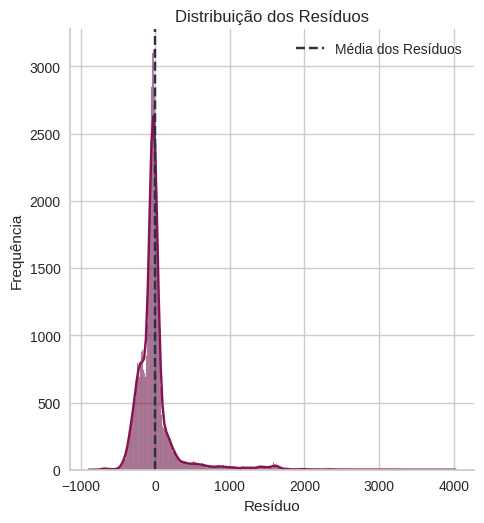

In [ ]:
# Cria o gráfico de distribuição dos resíduos
sns.displot(residuos, kde=True, color='#861454')

# Adiciona uma linha para a média dos resíduos
plt.axvline(x=residuos.mean(), color='#293049', linestyle='--', label='Média dos Resíduos')

# Adiciona uma legenda
plt.legend()

# Adiciona títulos
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

plt.show()

Vamos excluir as variáveis que obtiveram um p-valor superior a 0,05: tipo e faixa-etária

In [ ]:
X.drop(columns = ['Tipo', 'FaixaEtariaConsumidor_Nao Informada',
       'FaixaEtariaConsumidor_até 20 anos',
       'FaixaEtariaConsumidor_entre 21 a 30 anos',
       'FaixaEtariaConsumidor_entre 31 a 40 anos',
       'FaixaEtariaConsumidor_entre 41 a 50 anos',
       'FaixaEtariaConsumidor_entre 51 a 60 anos',
       'FaixaEtariaConsumidor_entre 61 a 70 anos',
       'FaixaEtariaConsumidor_mais de 70 anos'], inplace = True)

In [ ]:
#Exibir o sumário detalhado do modelo de regressão linear múltipla
import statsmodels.api as sm

#adicionando um constante de intercepto ao modelo
X = sm.add_constant(X)

#criar o modelo de regressão linear
model = sm.OLS(y, X).fit()

#imprimir o sumário do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      DiferencaTempoNum   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     818.8
Date:                Fri, 26 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:48:24   Log-Likelihood:            -7.3243e+05
No. Observations:              102461   AIC:                         1.465e+06
Df Residuals:                  102436   BIC:                         1.465e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4093    

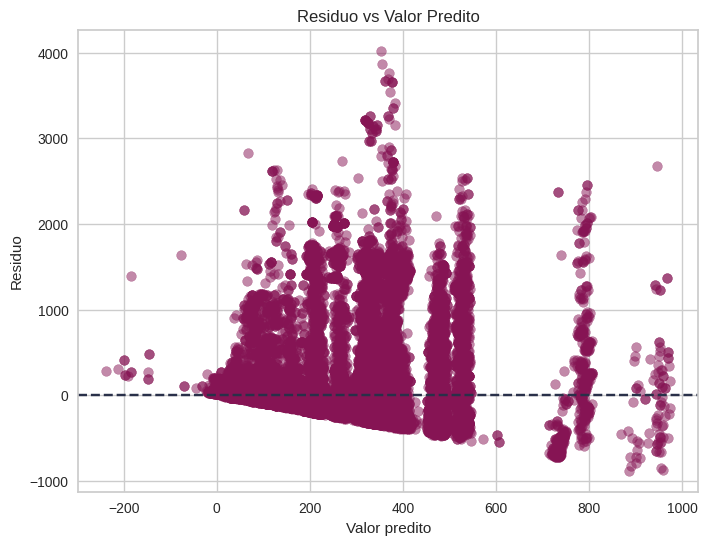

In [ ]:
# Salvamos os dados dos resíduos na variável residuos
residuos = model.resid

# Calculamos os valores preditos
predicted_values = model.fittedvalues

#Verificação através de scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuos, color='#861454', alpha=0.5)

# adiciona linha
plt.axhline(y=0, color='#293049', linestyle='--')

# Títulos
plt.title('Residuo vs Valor Predito')
plt.xlabel('Valor predito')
plt.ylabel('Residuo')

plt.show()

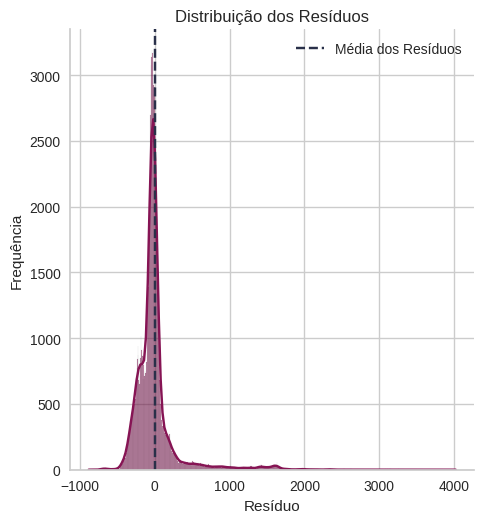

In [ ]:
# Cria o gráfico de distribuição dos resíduos
sns.displot(residuos, kde=True, color='#861454')

# Adiciona uma linha para a média dos resíduos
plt.axvline(x=residuos.mean(), color='#293049', linestyle='--', label='Média dos Resíduos')

# Adiciona uma legenda
plt.legend()

# Adiciona títulos
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

plt.show()

In [ ]:
# Removendo as regiões da análise
X = df_lr[['Atendida', 'CodigoAssunto', 'SexoConsumidor', 'CEPConsumidor',
           'UF_BA', 'UF_CE', 'UF_ES', 'UF_GO', 'UF_MA', 'UF_MG', 'UF_MS', 'UF_MT',
           'UF_PA', 'UF_PB', 'UF_PE', 'UF_PI', 'UF_PR', 'UF_RJ', 'UF_RN', 'UF_RO',
           'UF_RS', 'UF_SC', 'UF_SP', 'UF_TO']]

In [ ]:
#Exibir o sumário detalhado do modelo de regressão linear múltipla
import statsmodels.api as sm

#adicionando um constante de intercepto ao modelo
X = sm.add_constant(X)

#criar o modelo de regressão linear
model = sm.OLS(y, X).fit()

#imprimir o sumário do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      DiferencaTempoNum   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     852.7
Date:                Fri, 26 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:48:28   Log-Likelihood:            -7.3244e+05
No. Observations:              102461   AIC:                         1.465e+06
Df Residuals:                  102437   BIC:                         1.465e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -23.3889     17.315     -1.

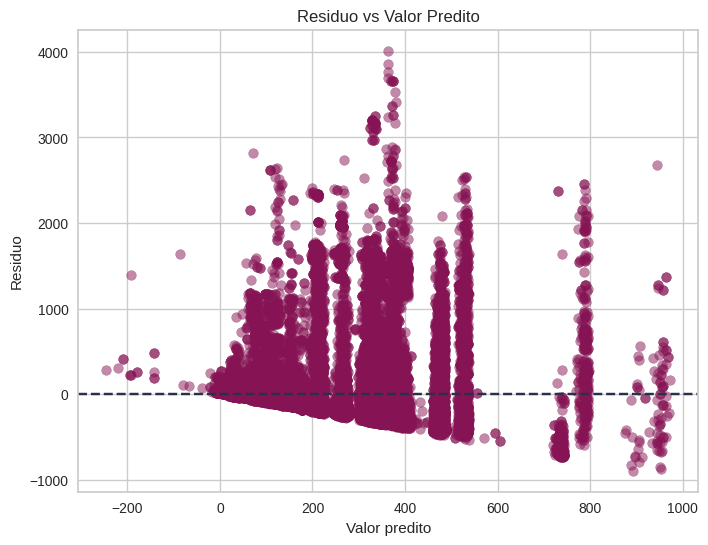

In [ ]:
#ANÁLISE DOS RESÍDUOS

# Salvamos os dados dos resíduos na variável residuos
residuos = model.resid

# Calculamos os valores preditos
predicted_values = model.fittedvalues

#Verificação através de scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuos, color='#861454', alpha=0.5)

# adiciona linha
plt.axhline(y=0, color='#293049', linestyle='--')

# Títulos
plt.title('Residuo vs Valor Predito')
plt.xlabel('Valor predito')
plt.ylabel('Residuo')

plt.show()

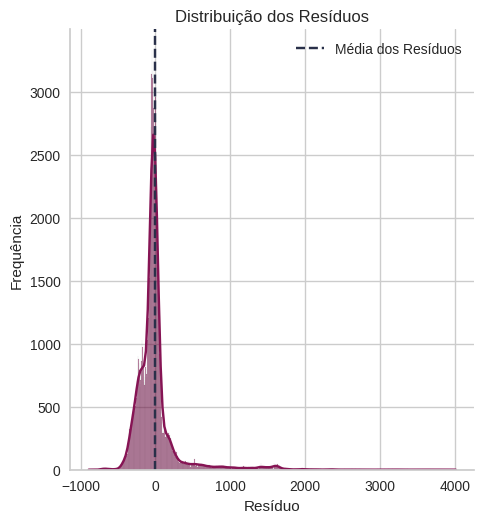

In [ ]:
# Cria o gráfico de distribuição dos resíduos
sns.displot(residuos, kde=True, color='#861454')

# Adiciona uma linha para a média dos resíduos
plt.axvline(x=residuos.mean(), color='#293049', linestyle='--', label='Média dos Resíduos')

# Adiciona uma legenda
plt.legend()

# Adiciona títulos
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

plt.show()

O modelo de regressão linear não se ajusta bem para previsão do tempo de reclamação ativa levando em consideração os dados disponíveis.
Rodamos um modelo de RandomForestRegressor:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df_lr.copy()
X.drop(columns = ['DiferencaTempoNum'], inplace = True)
y = df_lr['DiferencaTempoNum']

#Dividir conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Realizando previsões
y_pred = model.predict(X_test)

In [ ]:
# Métricas de avaliação do modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')

MSE: 33242.48
RMSE: 182.33
MAE: 73.41
R²: 0.70


O R² observou ser bem mais preciso (0.67) ao utilizar outro modelo de regressão, em comparação com o de regressão linear.

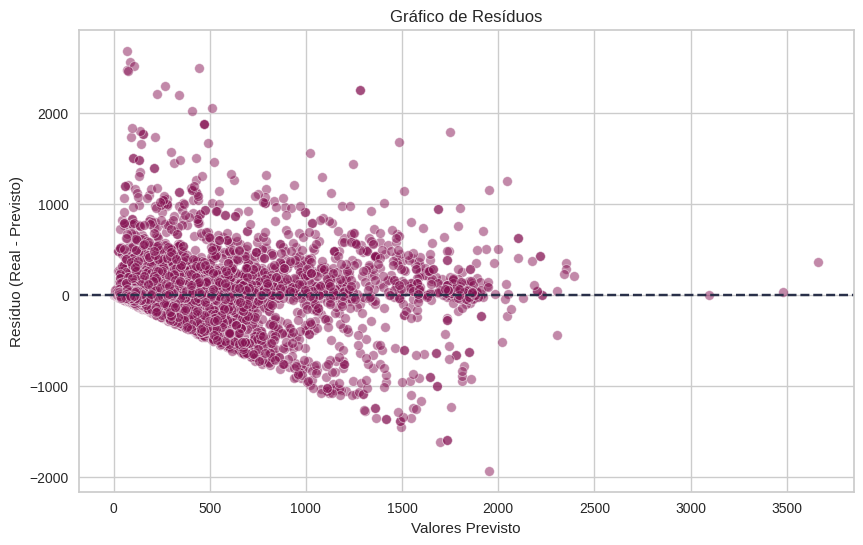

In [ ]:
# Calculando a diferença (resíduos)
residuals = y_test - y_pred

# Criando um DataFrame para o gráfico
results = pd.DataFrame({'Real': y_test, 'Previsto': y_pred, 'Resíduo': residuals})

# Plotando os resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Previsto', y='Resíduo', data=results, color='#861454', alpha=0.5)
plt.axhline(0, color='#293049', linestyle='--')
plt.xlabel('Valores Previsto')
plt.ylabel('Resíduo (Real - Previsto)')
plt.title('Gráfico de Resíduos')
plt.show()

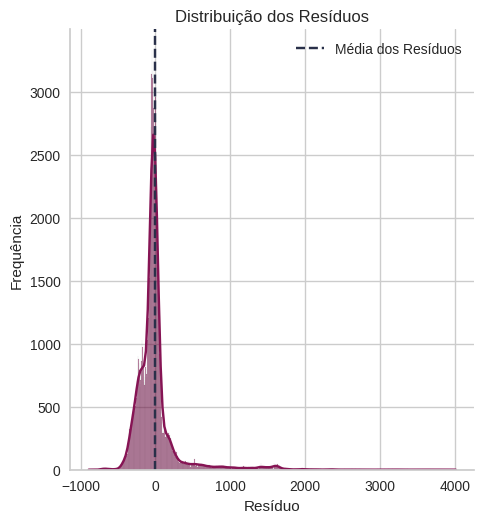

In [ ]:
# Cria o gráfico de distribuição dos resíduos
sns.displot(residuos, kde=True, color='#861454')

# Adiciona uma linha para a média dos resíduos
plt.axvline(x=residuos.mean(), color='#293049', linestyle='--', label='Média dos Resíduos')

# Adiciona uma legenda
plt.legend()

# Adiciona títulos
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

plt.show()